Creating Path with step 3
Generazione plot per 11 distribuzioni...
Salvato grafico riassuntivo in: /Users/Q540900/Desktop/Direct_Preference_Learning_LLM_Thesis/preferencelearning-main/comparison/outputs/thesis_distributions_overview.png


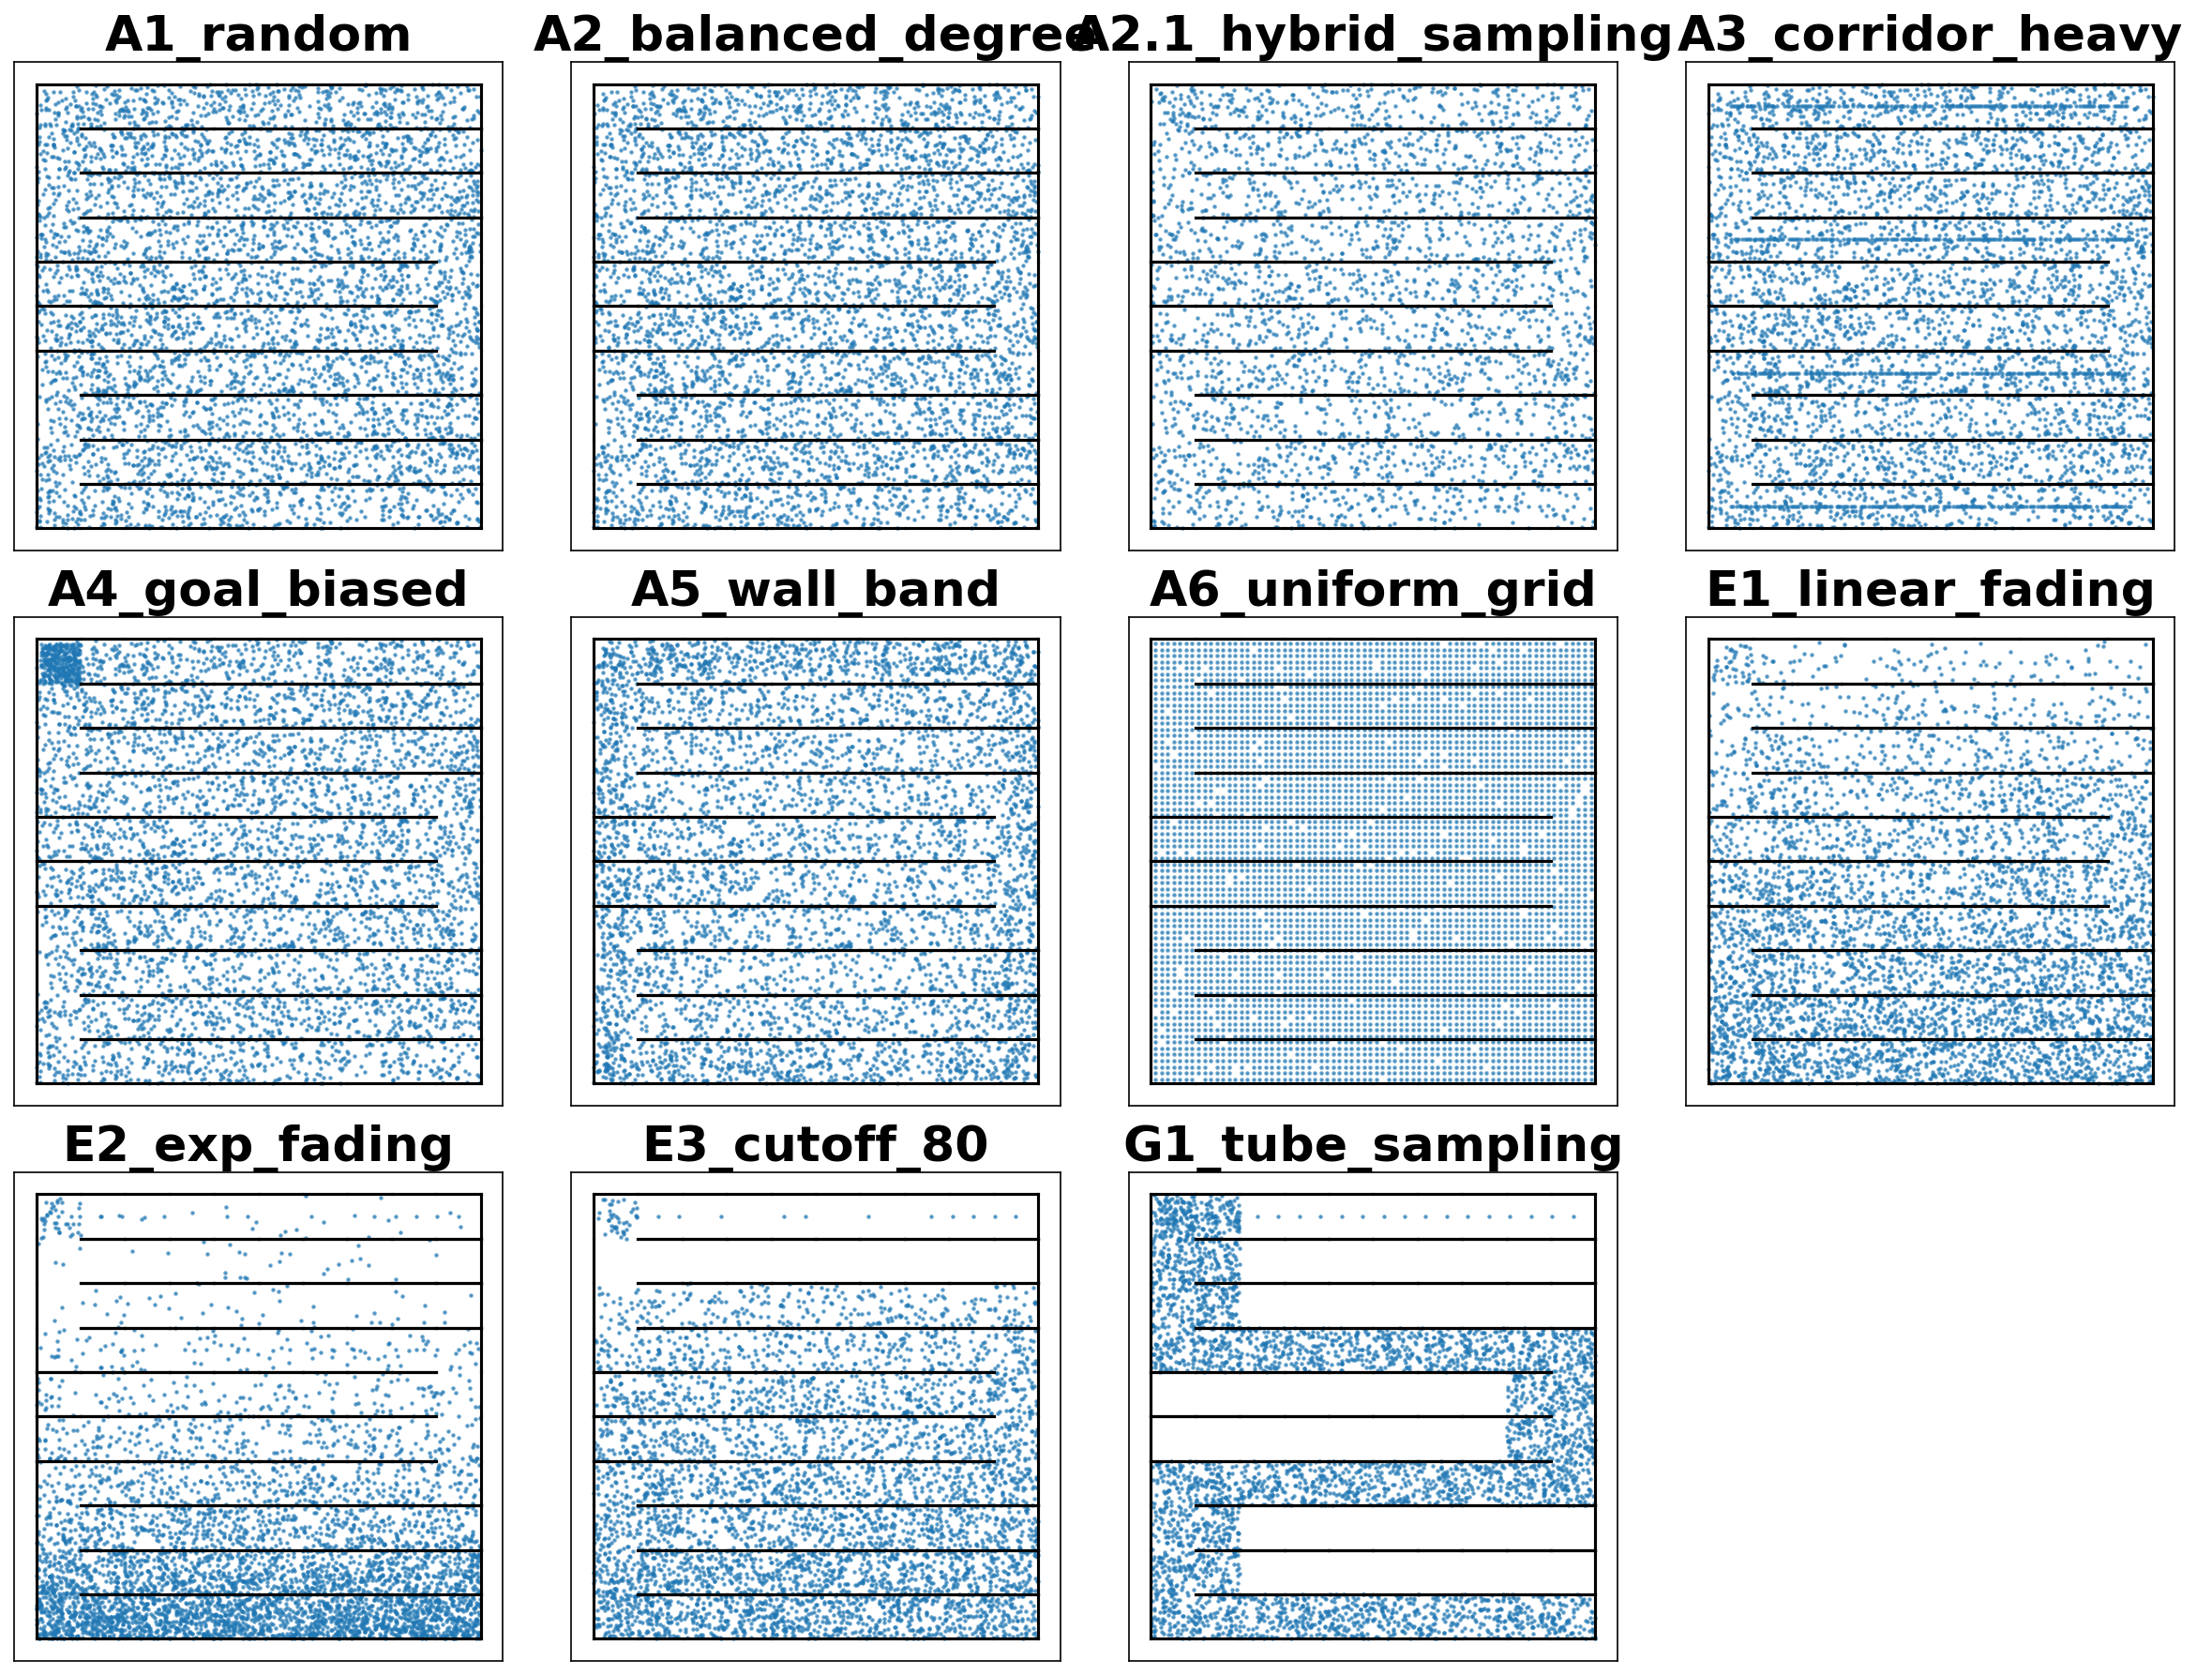

In [1]:
import os, sys, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIGURAZIONE PATH ---
BASE = Path.cwd()
# Gestione robusta dei path se lanci da notebook o da script
if BASE.name == "comparison":
    OUTPUTS_DIR = BASE / "outputs"
    SRC_DIR = BASE.parent / "src"
elif (BASE / "comparison").exists():
    OUTPUTS_DIR = BASE / "comparison" / "outputs"
    SRC_DIR = BASE / "src"
else:
    # Fallback se sei dentro outputs o altrove
    OUTPUTS_DIR = BASE 
    SRC_DIR = BASE.parent.parent / "src"

sys.path.insert(0, str(SRC_DIR))
from maze import Maze
from maze_env import draw_map 

# --- SELEZIONE TEST SIGNIFICATIVI ---
# Includiamo solo quelli che hanno una distribuzione spaziale diversa
SELECTED_TESTS = [
    # Gruppo A: Strategie di copertura
    "A1_random", 
    "A2_balanced_degree", 
    "A2.1_hybrid_sampling",
    "A3_corridor_heavy", 
    "A4_goal_biased", 
    "A5_wall_band",
    "A6_uniform_grid",
    
    # Gruppo E: Scarcity / Fading
    "E1_linear_fading", 
    "E2_exp_fading", 
    "E3_cutoff_80",
    
    # Gruppo G: Imitation
    "G1_tube_sampling"
]

# Configurazione Grafica
N_COLS = 4
SCATTER_SIZE = 1.5  # Punti piccoli per vedere la densità
ALPHA = 0.6         # Trasparenza per vedere le sovrapposizioni
SEED = 42

# Setup Maze (Serpentina step=3)
maze = Maze(10, 10, 0, 0)
maze.make_maze_fail(step=3)

def plot_selected_distributions():
    # Calcola righe necessarie
    n_plots = len(SELECTED_TESTS)
    n_rows = math.ceil(n_plots / N_COLS)
    
    fig, axes = plt.subplots(n_rows, N_COLS, figsize=(16, 4 * n_rows), dpi=150)
    axes = axes.ravel()
    
    print(f"Generazione plot per {n_plots} distribuzioni...")

    for i, test_id in enumerate(SELECTED_TESTS):
        ax = axes[i]
        test_path = OUTPUTS_DIR / test_id / "positions.parquet"
        
        # Disegna Muri
        draw_map(1/10, maze, ax=ax, alpha=1.0)
        
        # Disegna Punti
        if test_path.exists():
            df = pd.read_parquet(test_path)
            # Sottocampionamento se troppi punti (per leggibilità)
            if len(df) > 5000:
                df = df.sample(5000, random_state=SEED)
                
            ax.scatter(df["x"].values, df["y"].values, s=SCATTER_SIZE, alpha=ALPHA, color='#1f77b4')
            ax.set_title(test_id, fontsize=25, fontweight='bold')
        else:
            ax.text(0.5, 0.5, "Data Not Found", ha='center', va='center', color='red')
            ax.set_title(test_id, fontsize=25, color='gray')

        # Cleanup assi
        ax.set_aspect("equal")
        ax.invert_xaxis()
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis("on") # Mantiene il bordo per incorniciare il maze


    # Nascondi subplot vuoti
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    
    # Salva
    out_file = OUTPUTS_DIR / "thesis_distributions_overview.png"
    plt.savefig(out_file, bbox_inches='tight')
    print(f"Salvato grafico riassuntivo in: {out_file}")
    plt.show()

if __name__ == "__main__":
    plot_selected_distributions()

In [2]:
# # Diagnostica mismatch: policy_legal vs step_collision
# import sys, os, numpy as np
# from pathlib import Path

# BASE = Path.cwd()
# SRC = BASE / "src" if (BASE / "src").is_dir() else BASE.parent / "src"
# sys.path.insert(0, str(SRC))

# from maze import Maze
# from maze_env import MazeEnv

# def candidate_actions(env):
#     angles = np.linspace(-1, 1, 32, endpoint=False, dtype=np.float32)
#     fine = [0.002, 0.005, 0.008]
#     speeds = fine + [0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.8]
#     cell = 1.0 / env.sz
#     speeds = [0.5*cell/env.dt, 0.8*cell/env.dt, cell/env.dt] + speeds
#     a, s = np.meshgrid(angles, speeds)
#     return np.stack([s.ravel(), a.ravel()], axis=1)

# def is_legal_policy(env, s_from, s_to, n=4):
#     # quello che usavamo nel rollout: campionamento + segment_collision (strict=True)
#     alphas = np.linspace(0., 1., n)
#     for a in alphas:
#         p = (1-a)*s_from + a*s_to
#         if env.point_collision(p[0], p[1]):
#             return False
#     return not env.segment_collision(s_from, s_to)  # strict=True dentro la definizione

# def step_would_collide(env, s_to):
#     # esattamente ciò che fa step() per la collisione del segmento start->s_to
#     return env.collision(s_to)

# # -- setup env baseline
# maze = Maze(10,10,0,0)
# env  = MazeEnv(sz=10, maze=maze, start=np.array([0.05,0.05]),
#                goal=np.array([0.95,0.95]), reward="distance",
#                dt=0.15, horizon=180, slide=1, use_dpo=False)

# acts = candidate_actions(env)

# for t in range(20):  # pochi step di diagnostica
#     next_states = env.state + np.stack(
#         [acts[:,0]*np.cos(acts[:,1]*np.pi)*env.dt,
#          acts[:,0]*np.sin(acts[:,1]*np.pi)*env.dt], axis=1)

#     pol_legal = []
#     step_ok   = []
#     mismatch  = []
#     for i, s1 in enumerate(next_states):
#         Lp = is_legal_policy(env, env.state, s1)
#         Ls = not step_would_collide(env, s1)
#         pol_legal.append(Lp)
#         step_ok.append(Ls)
#         mismatch.append(Lp and (not Ls))

#     print(f"step {t:02d} | policy_legal={np.sum(pol_legal)} | step_ok={np.sum(step_ok)} | mismatch={np.sum(mismatch)} | dist={np.linalg.norm(env.goal-env.state):.3f}")

#     # muovi con una mossa sicura secondo LO STESSO criterio dello step (per avanzare)
#     idxs_ok = np.where(np.array(step_ok))[0]
#     if len(idxs_ok)==0:
#         # resta fermo (diagnostica)
#         pass
#     else:
#         # prendi fra quelle ok quella che più riduce la distanza
#         dists = np.linalg.norm(env.goal - next_states[idxs_ok], axis=1)
#         a = acts[idxs_ok[np.argmin(dists)]]
#         new_pose = env.state + a[0]*env.dt*np.array([np.cos(a[1]*np.pi), np.sin(a[1]*np.pi)])
#         env.step(a, epsilon_goal=0.106)
#     if np.linalg.norm(env.goal - env.state) < 0.106:
#         print("✅ goal raggiunto durante la diagnostica")
#         break


In [3]:
# # Diagnostica: quante azioni legali riducono (a) distanza euclidea e (b) distanza di percorso (BFS)?
# import sys, os, numpy as np
# from pathlib import Path
# from collections import deque

# BASE = Path.cwd()
# SRC = BASE / "src" if (BASE / "src").is_dir() else BASE.parent / "src"
# sys.path.insert(0, str(SRC))

# from maze import Maze
# from maze_env import MazeEnv

# def candidate_actions(env):
#     angles = np.linspace(-1, 1, 32, endpoint=False, dtype=np.float32)
#     fine = [0.002, 0.005, 0.008]
#     speeds = fine + [0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.8]
#     cell = 1.0 / env.sz
#     speeds = [0.5*cell/env.dt, 0.8*cell/env.dt, cell/env.dt] + speeds
#     a, s = np.meshgrid(angles, speeds)
#     return np.stack([s.ravel(), a.ravel()], axis=1)

# def can_move(env, cx, cy, nx, ny):
#     if nx < 0 or nx >= env.maze.nx or ny < 0 or ny >= env.maze.ny:
#         return False
#     if all(env.maze.cell_at(nx, ny).walls.values()):
#         return False
#     c  = env.maze.cell_at(cx, cy)
#     n  = env.maze.cell_at(nx, ny)
#     dx, dy = nx - cx, ny - cy
#     if   dx==0 and dy==-1 and (c.walls["N"] or n.walls["S"]): return False
#     elif dx==0 and dy== 1 and (c.walls["S"] or n.walls["N"]): return False
#     elif dx== 1 and dy==0  and (c.walls["E"] or n.walls["W"]): return False
#     elif dx==-1 and dy==0  and (c.walls["W"] or n.walls["E"]): return False
#     return True

# def shortest_path_cells(env, s):
#     cx, cy = min(int(s[0]*env.sz), env.maze.nx-1), min(int(s[1]*env.sz), env.maze.ny-1)
#     gx, gy = min(int(env.goal[0]*env.sz), env.maze.nx-1), min(int(env.goal[1]*env.sz), env.maze.ny-1)
#     dist = { (cx,cy): 0 }
#     Q = deque([(cx,cy)])
#     while Q:
#         ux, uy = Q.popleft()
#         if (ux,uy) == (gx,gy): break
#         for dx,dy in [(-1,0),(1,0),(0,-1),(0,1)]:
#             vx, vy = ux+dx, uy+dy
#             if not can_move(env, ux, uy, vx, vy): continue
#             if (vx,vy) not in dist:
#                 dist[(vx,vy)] = dist[(ux,uy)] + 1
#                 Q.append((vx,vy))
#     return dist.get((gx,gy), np.inf)

# # Setup
# maze = Maze(10,10,0,0)
# env  = MazeEnv(sz=10, maze=maze, start=np.array([0.05,0.05]),
#                goal=np.array([0.95,0.95]), reward="distance",
#                dt=0.15, horizon=180, slide=1, use_dpo=False)
# acts = candidate_actions(env)

# for t in range(20):
#     next_states = env.state + np.stack(
#         [acts[:,0]*np.cos(acts[:,1]*np.pi)*env.dt,
#          acts[:,0]*np.sin(acts[:,1]*np.pi)*env.dt], axis=1)

#     # legali secondo lo step (segmento non collide)
#     idxs_ok = [i for i in range(len(acts)) if not env.collision(next_states[i])]

#     d0 = float(np.linalg.norm(env.goal - env.state))
#     p0 = shortest_path_cells(env, env.state)

#     dists = np.linalg.norm(env.goal - next_states[idxs_ok], axis=1)
#     paths = np.array([shortest_path_cells(env, s) for s in next_states[idxs_ok]])

#     eu_improve   = np.sum(dists < d0 - 1e-6)
#     path_improve = np.sum(paths < p0 - 1e-9)

#     print(f"step {t:02d} | legal={len(idxs_ok)} | eu_improve={eu_improve} | path_improve={path_improve} | dist={d0:.3f} | path={p0}")

#     # muovi con criterio dello step per proseguire
#     if len(idxs_ok)==0:
#         break
#     # prova prima euclidea; se none, scegli min path
#     if eu_improve > 0:
#         i = idxs_ok[np.argmin(dists)]
#     else:
#         i = idxs_ok[np.argmin(paths)]
#     a = acts[i]
#     env.step(a, epsilon_goal=0.106)
#     if np.linalg.norm(env.goal - env.state) < 0.106:
#         print("✅ goal raggiunto (diagnostica)")
#         break


DPO wins: 5 | ties: 3 | losses: 12 | avg Δsteps (baseline−DPO): -1.80


,test_id,n_points,n_pairs,best_val,test_accuracy,dpo_steps,baseline_steps,delta_steps
0,A1_random,6000,200000,0.026504,0.964100,28.0,29,1.0
1,A2.1_hybrid_sampling,3060,200000,0.028398,0.956500,35.0,29,-6.0
2,A2_balanced_degree,6040,200000,0.028078,0.958400,33.0,29,-4.0
3,A3_corridor_heavy,6800,200000,0.023446,0.969100,28.0,29,1.0
4,A4_goal_biased,6440,200000,0.027870,0.962100,29.0,29,0.0
5,A5_wall_band,7540,200000,0.026390,0.962600,29.0,29,0.0
6,A6_uniform_grid,5184,200000,0.021175,0.970700,31.0,29,-2.0
7,B1_deg_strong,4080,200000,0.039795,0.936500,30.0,29,-1.0
8,B2_goal_strong,4080,200000,0.022856,0.969100,NaN,29,NaN
9,B3.1_efficient_safety,4080,200000,0.094807,0.849800,NaN,29,NaN


✓ Salvato CSV: /Users/Q540900/Desktop/Direct_Preference_Learning_LLM_Thesis/preferencelearning-main/comparison/outputs/_metrics_summary.csv


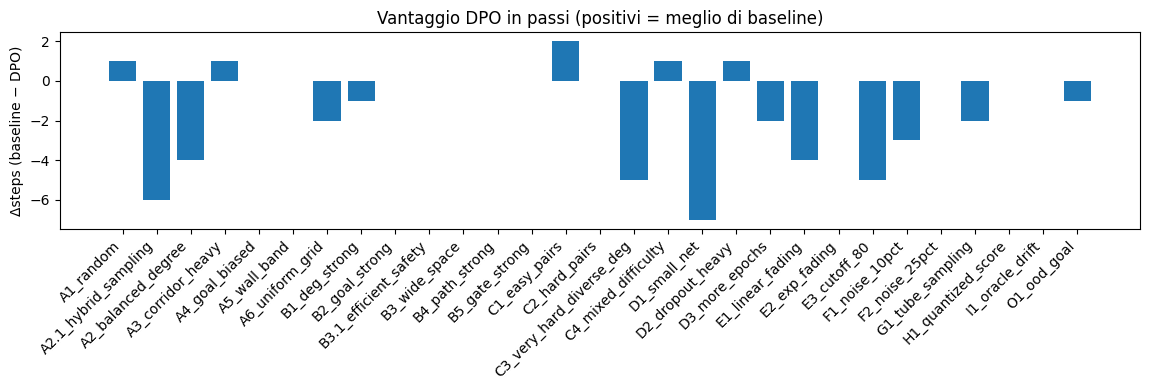

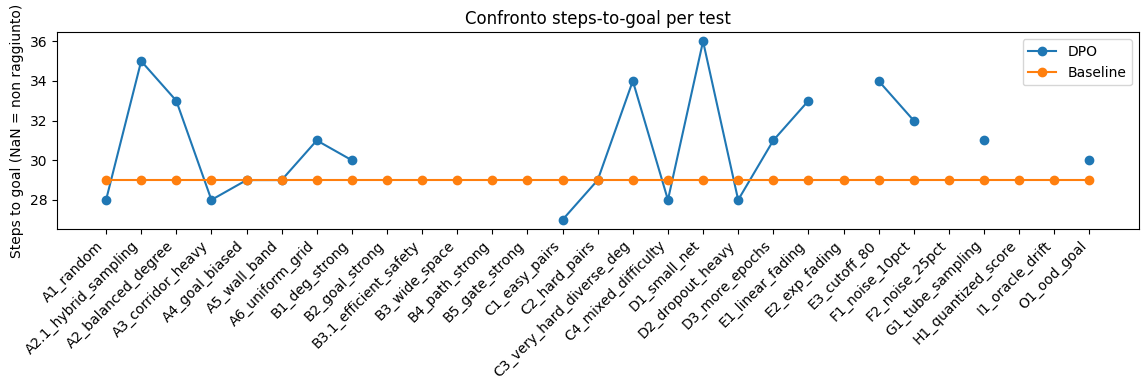

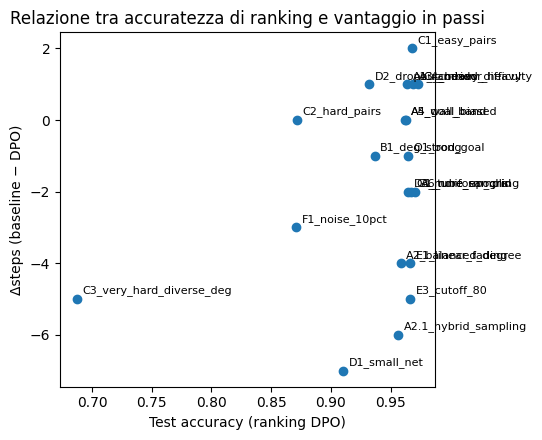

In [4]:
# ## Confronto numerico dai report.json
# - Aggrega metriche
# - Calcola delta_steps = baseline - dpo
# - Mostra tabella e tre grafici separati
import os, sys, json, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

warnings.filterwarnings("ignore", category=UserWarning)

def find_outputs_dir():
    candidates = [
        Path.cwd() / "outputs",
        Path.cwd() / "comparison" / "outputs",
        Path.cwd().parent / "comparison" / "outputs",
        Path.cwd().parent.parent / "comparison" / "outputs",
    ]
    for p in candidates:
        if p.is_dir():
            return p.resolve()
    raise FileNotFoundError("Non trovo 'comparison/outputs'. Apri il notebook dentro 'comparison/' o aggiorna i path.")

OUTPUTS_DIR = find_outputs_dir()

# --- carica report.json di tutti i test ---
records = []
for tdir in sorted(OUTPUTS_DIR.iterdir()):
    if not tdir.is_dir(): 
        continue
    rpath = tdir / "report.json"
    if not rpath.exists():
        continue
    with open(rpath, "r") as f:
        rep = json.load(f)

    # safe cast: -1 -> NaN (non raggiunto)
    def ok_steps(x):
        try:
            v = int(x)
            return np.nan if v < 0 else v
        except Exception:
            return np.nan

    rec = {
        "test_id": rep.get("test_id", tdir.name),
        "n_points": rep.get("n_points", np.nan),
        "n_pairs": rep.get("n_pairs", np.nan),
        "best_val": rep.get("training", {}).get("best_val", np.nan),
        "test_accuracy": rep.get("training", {}).get("test_accuracy", np.nan),
        "dpo_steps": ok_steps(rep.get("solve", {}).get("dpo_steps_to_goal", np.nan)),
        "baseline_steps": ok_steps(rep.get("solve", {}).get("baseline_steps_to_goal", np.nan)),
    }
    # delta positivo = DPO meglio (meno passi)
    if np.isnan(rec["dpo_steps"]) or np.isnan(rec["baseline_steps"]):
        rec["delta_steps"] = np.nan
    else:
        rec["delta_steps"] = rec["baseline_steps"] - rec["dpo_steps"]

    records.append(rec)

df = pd.DataFrame(records).sort_values("test_id").reset_index(drop=True)

# --- sintesi globale ---
wins = int((df["delta_steps"] > 0).sum())
ties = int((df["delta_steps"] == 0).sum())
loss = int((df["delta_steps"] < 0).sum())
avg_impr = float(df["delta_steps"].dropna().mean()) if df["delta_steps"].notna().any() else np.nan
print(f"DPO wins: {wins} | ties: {ties} | losses: {loss} | avg Δsteps (baseline−DPO): {avg_impr:.2f}")

# --- tabella interattiva + CSV
try:
    import ace_tools
    ace_tools.display_dataframe_to_user("Confronto numerico per test", df)
except Exception:
    display(df)

summary_csv = OUTPUTS_DIR / "_metrics_summary.csv"
df.to_csv(summary_csv, index=False)
print(f"✓ Salvato CSV: {summary_csv}")

# --- GRAFICO 1: Δsteps (baseline - DPO) per test
plt.figure(figsize=(max(6, 0.4*len(df)), 4))
plt.bar(df["test_id"], df["delta_steps"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Δsteps (baseline − DPO)")
plt.title("Vantaggio DPO in passi (positivi = meglio di baseline)")
plt.tight_layout()
plt.savefig(OUTPUTS_DIR / "_delta_steps.png", dpi=150)
plt.show()

# --- GRAFICO 2: Steps to goal per test (DPO vs Baseline)
plt.figure(figsize=(max(6, 0.4*len(df)), 4))
plt.plot(df["test_id"], df["dpo_steps"], marker="o", label="DPO")
plt.plot(df["test_id"], df["baseline_steps"], marker="o", label="Baseline")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Steps to goal (NaN = non raggiunto)")
plt.title("Confronto steps-to-goal per test")
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUTS_DIR / "_steps_comparison.png", dpi=150)
plt.show()

# --- GRAFICO 3: test_accuracy vs Δsteps
plt.figure(figsize=(5.5, 4.5))
plt.scatter(df["test_accuracy"], df["delta_steps"])
for i, row in df.iterrows():
    plt.annotate(row["test_id"], (row["test_accuracy"], row["delta_steps"]), fontsize=8, xytext=(4,4), textcoords="offset points")
plt.xlabel("Test accuracy (ranking DPO)")
plt.ylabel("Δsteps (baseline − DPO)")
plt.title("Relazione tra accuratezza di ranking e vantaggio in passi")
plt.tight_layout()
plt.savefig(OUTPUTS_DIR / "_acc_vs_delta.png", dpi=150)
plt.show()


Test: A3_corridor_heavy
DPO steps: 28
Baseline steps: 29
Creating Path with step 3
Creating Path with step 3
Step called. Counter: 0, Horizon: 240
Step called. Counter: 1, Horizon: 240
Step called. Counter: 2, Horizon: 240
Step called. Counter: 3, Horizon: 240
Step called. Counter: 4, Horizon: 240
Step called. Counter: 5, Horizon: 240
Step called. Counter: 6, Horizon: 240
Step called. Counter: 7, Horizon: 240
Step called. Counter: 8, Horizon: 240
Step called. Counter: 9, Horizon: 240
Step called. Counter: 10, Horizon: 240
Step called. Counter: 11, Horizon: 240
Step called. Counter: 12, Horizon: 240
Step called. Counter: 13, Horizon: 240
Step called. Counter: 14, Horizon: 240
Step called. Counter: 15, Horizon: 240
Step called. Counter: 16, Horizon: 240
Step called. Counter: 17, Horizon: 240
Step called. Counter: 18, Horizon: 240
Step called. Counter: 19, Horizon: 240
Step called. Counter: 20, Horizon: 240
Step called. Counter: 21, Horizon: 240
Step called. Counter: 22, Horizon: 240
Step

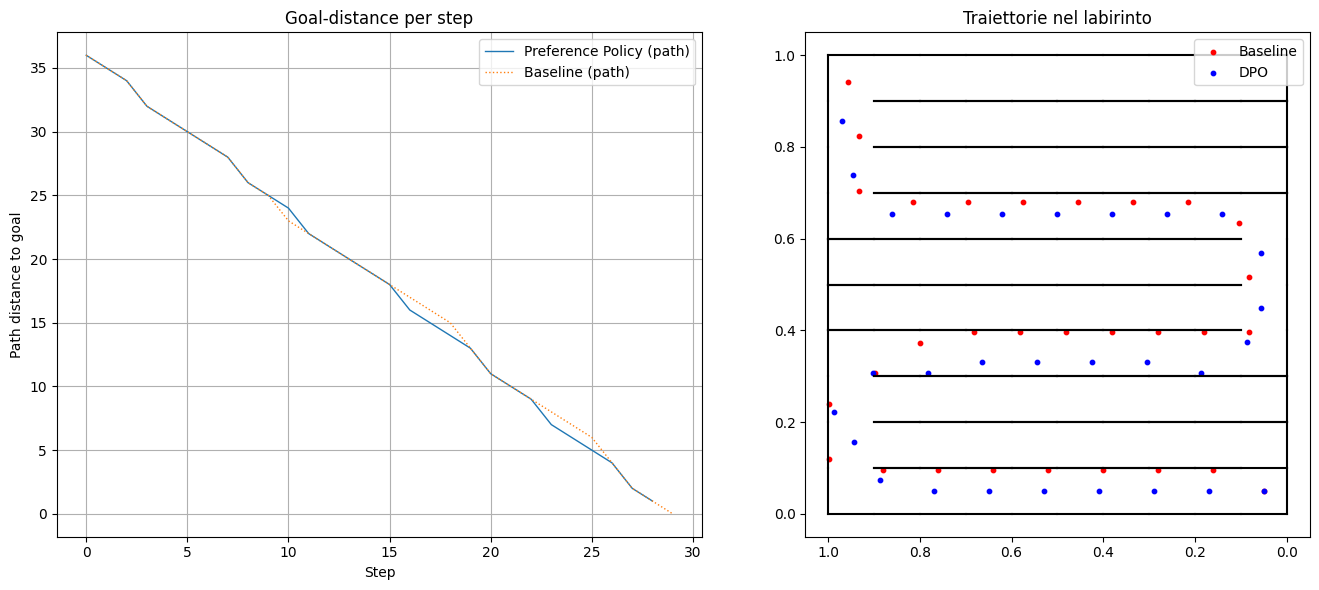

In [5]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

import os
import sys
import math
import time
import json
import random
from dataclasses import dataclass, asdict
from typing import Callable, Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# SciPy: usata solo per la euristica euclidea in A*
try:
    from scipy.spatial import distance as scipy_distance
except Exception:
    scipy_distance = None  # fallback

SRC_DIR  = '../src'
assert os.path.isdir(SRC_DIR), f"src non trovato in {SRC_DIR}"
sys.path.insert(0, SRC_DIR)

from maze_env import MazeEnv, draw_map
from maze import Maze

# ---------------------------------------------------------
# Seleziona test da visualizzare
# ---------------------------------------------------------
test_id = "A3_corridor_heavy"
root = "outputs"
test_dir = os.path.join(root, test_id)

# Carica report.json
with open(os.path.join(test_dir, "report.json"), "r") as f:
    report = json.load(f)

print("Test:", report["test_id"])
print("DPO steps:", report["solve"]["dpo_steps_to_goal"])
print("Baseline steps:", report["solve"]["baseline_steps_to_goal"])

# ---------------------------------------------------------
# Ricostruisci lo stesso ambiente usato nei rollouts
# ---------------------------------------------------------
maze = Maze(10, 10, 0, 0)
env_base = MazeEnv(
    sz=10, maze=maze,
    start=np.array([0.05,0.05]),
    goal=np.array([0.95,0.95]),
    use_dpo=False,
    dt=0.15, horizon=240
)

env_dpo = MazeEnv(
    sz=10, maze=maze,
    start=np.array([0.05,0.05]),
    goal=np.array([0.95,0.95]),
    use_dpo=True,
    dpo_model_path=os.path.join(test_dir, "best_dpo_policy.pth"),
    hidden_dim=256, num_layers=4, dropout_prob=0.05,
    dt=0.15, horizon=240
)

# Ricarica le statistiche di normalizzazione
stats = np.load("../tests/norm_stats.npz")
env_dpo._mean = torch.tensor(stats["mean"], dtype=torch.float32, device=env_dpo.device)
env_dpo._std  = torch.tensor(stats["std"] + 1e-8, dtype=torch.float32, device=env_dpo.device)

# ---------------------------------------------------------
# Funzioni di rollout (copiate dalla pipeline)
# ---------------------------------------------------------
from comparison import _policy_baseline_lexico, _policy_dpo_two_step_safe, _rollout

device = env_dpo.device


# DPO
# MODIFICA QUI: passiamo epsilon_goal alla policy
traj_dpo, dist_dpo, iter_dpo, path_dpo = _rollout(
    env_dpo, 
    lambda e: _policy_dpo_two_step_safe(e, device=device, epsilon_goal=0.106),
    max_steps=240, 
    epsilon_goal=0.12
)

traj_base, dist_base, iter_base, path_base = _rollout(
    env_base, _policy_baseline_lexico,
    max_steps=240, epsilon_goal=0.12
)

# ---------------------------------------------------------
# Visualizzazione
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# --- (1) distanza per step ---
axes[0].plot(path_dpo, label="Preference Policy (path)", lw=1)
axes[0].plot(path_base, label="Baseline (path)", lw=1, ls=":")
axes[0].set_xlabel("Step")
axes[0].set_ylabel("Path distance to goal")
axes[0].set_title("Goal-distance per step")
axes[0].grid(True)
axes[0].legend()

# --- (2) Mappa + traiettorie ---
draw_map(1/env_dpo.sz, env_dpo.maze, ax=axes[1], alpha=1.0)
axes[1].scatter(traj_base[:,0], traj_base[:,1], s=10, label="Baseline", color="red")
axes[1].scatter(traj_dpo[:,0],  traj_dpo[:,1],  s=10, label="DPO",      color="blue")

axes[1].invert_xaxis()
axes[1].set_aspect("equal")
axes[1].set_title("Traiettorie nel labirinto")
axes[1].legend()

plt.tight_layout()
plt.show()


Generazione grafici migliorati...


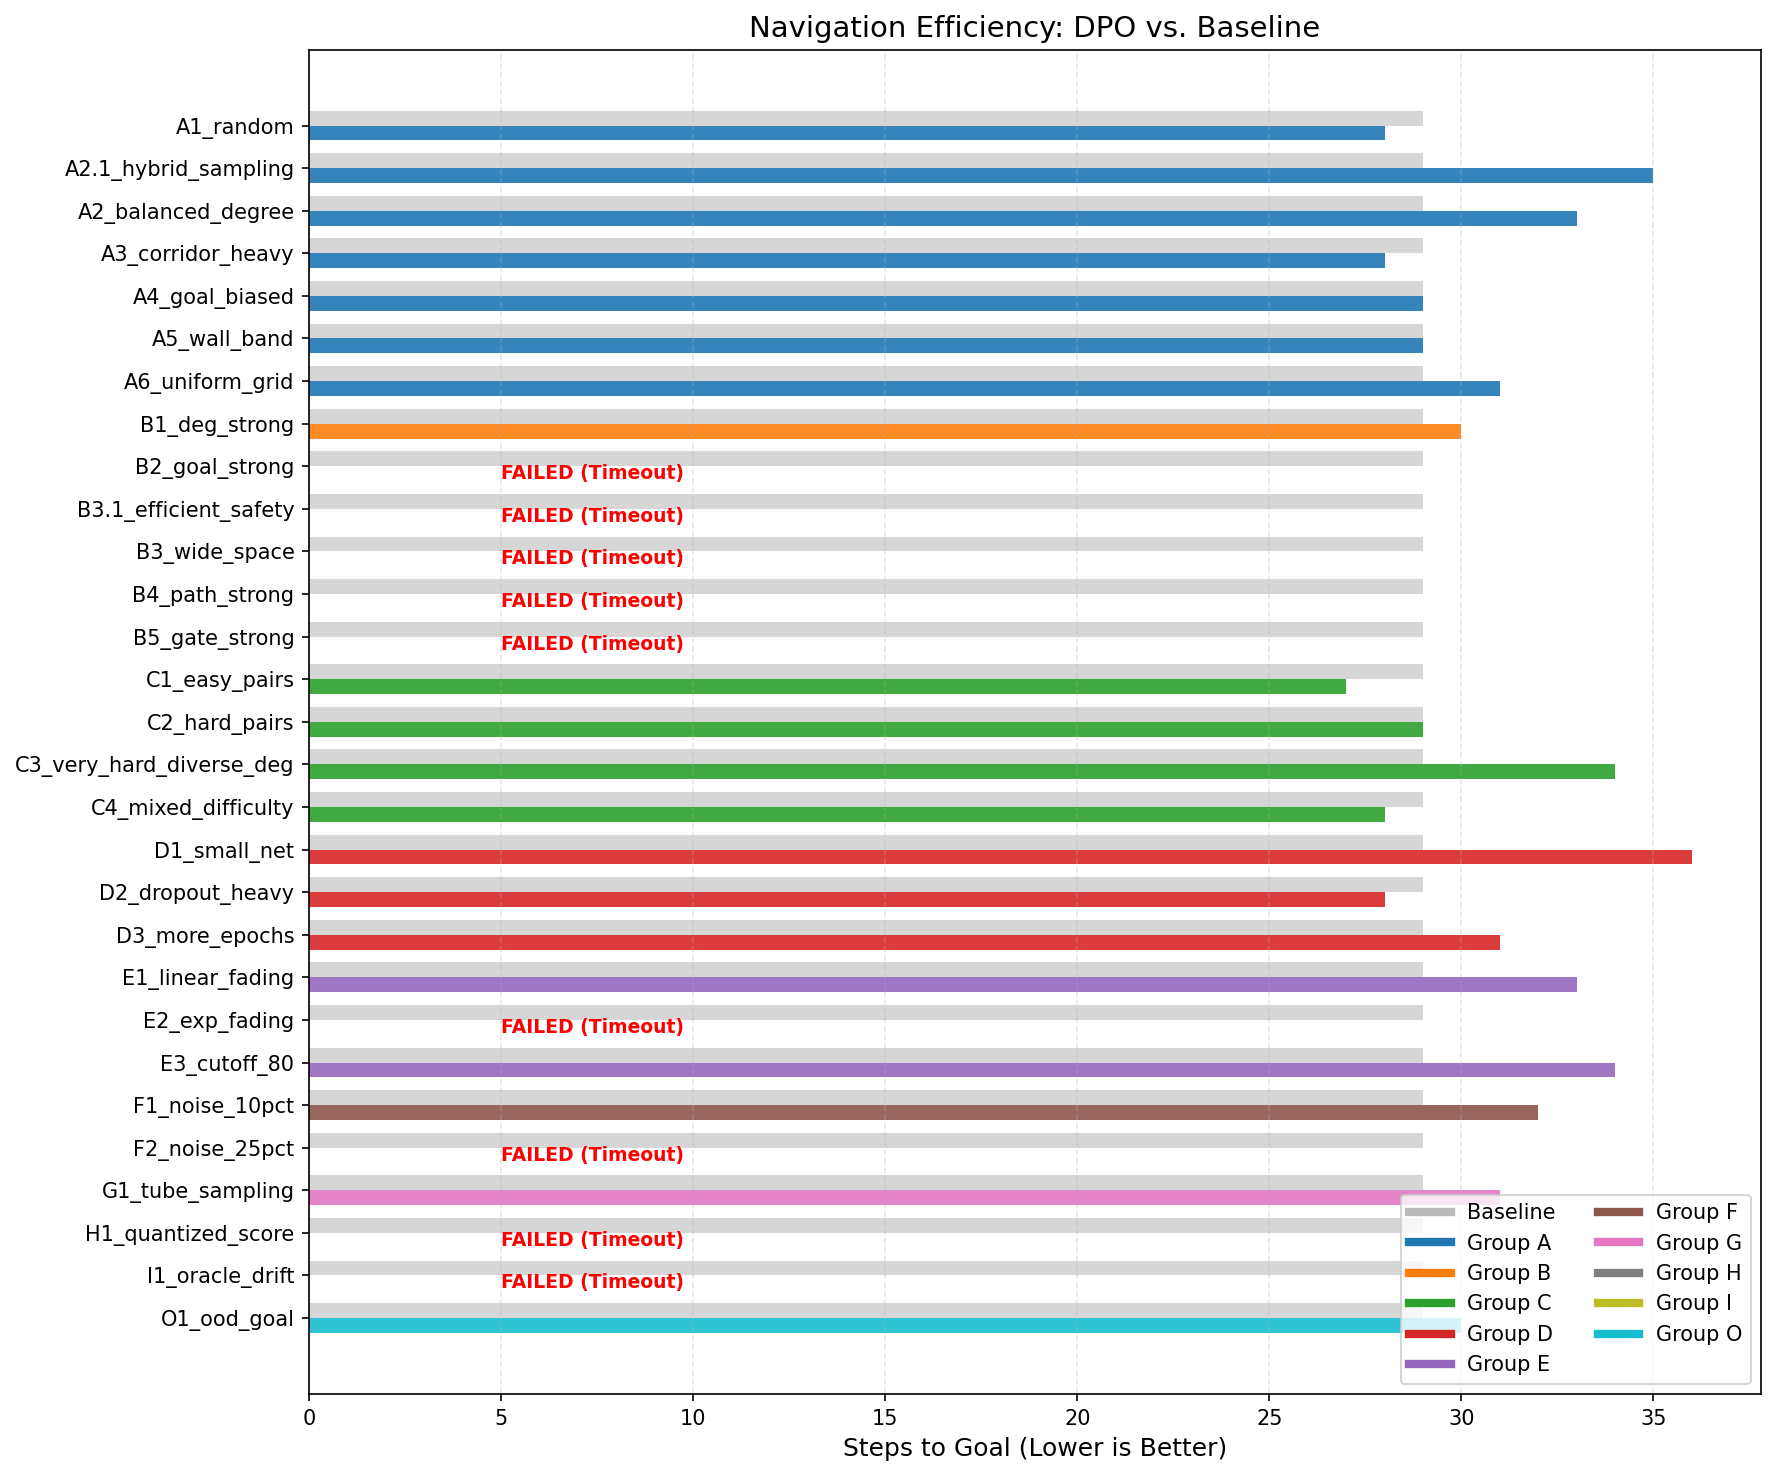

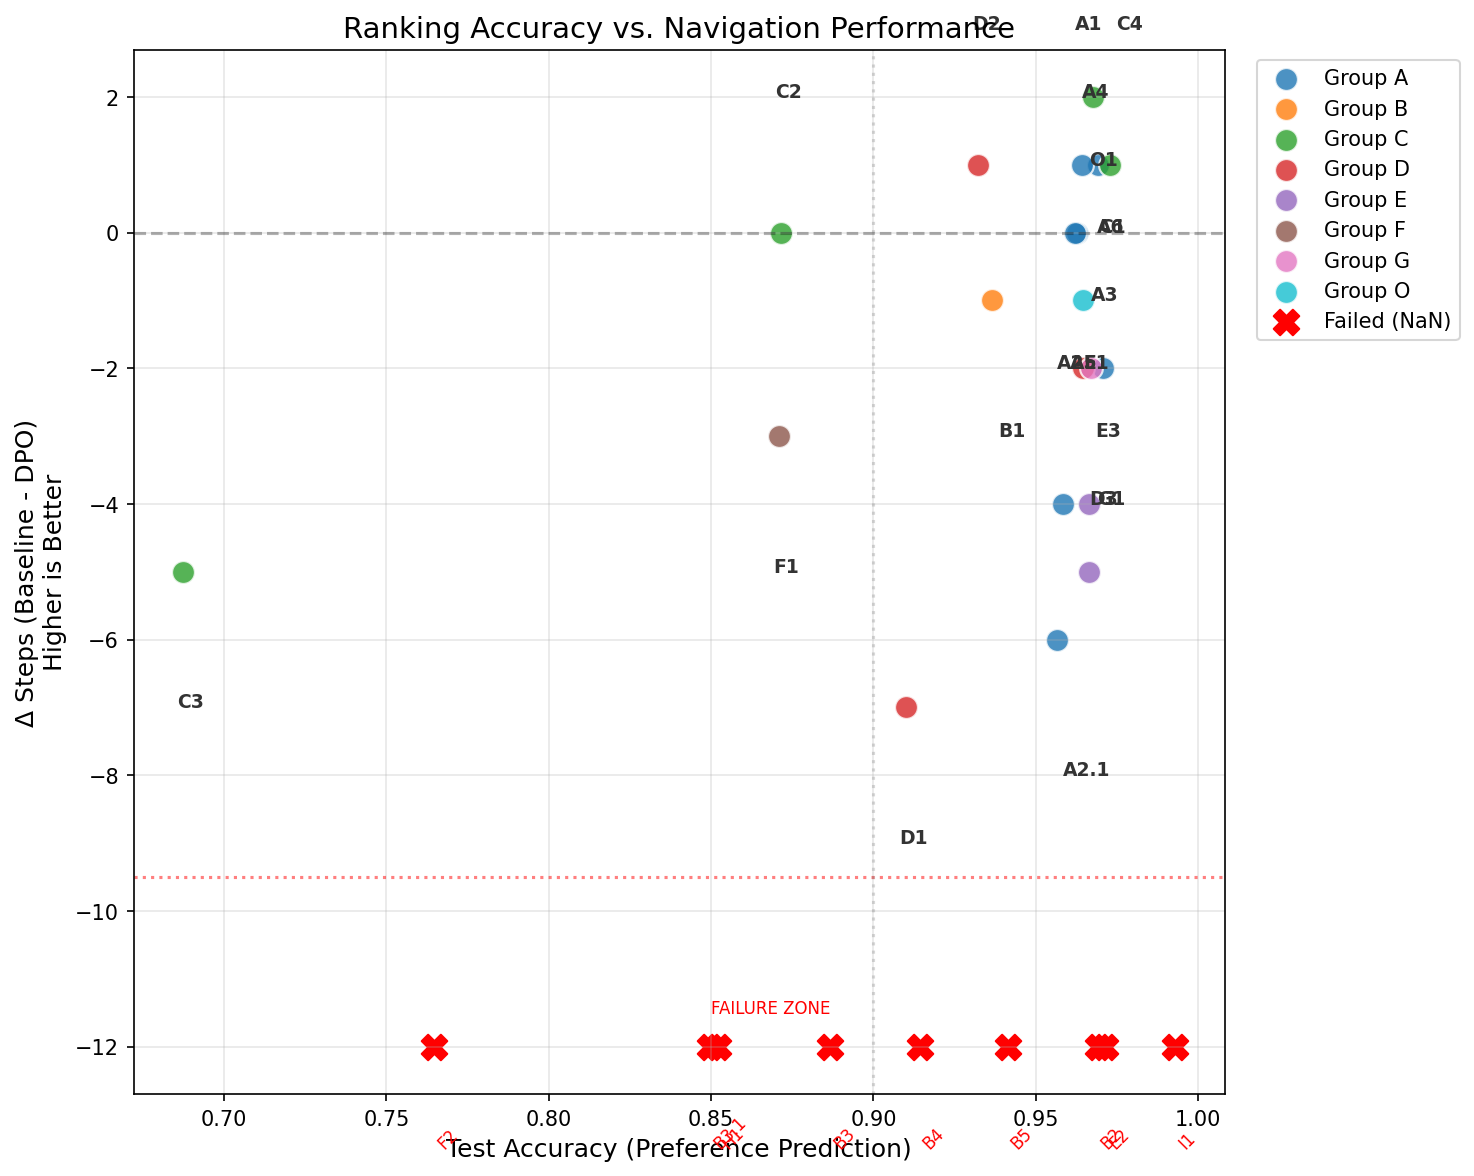

Fatto.


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# --- CONFIGURAZIONE STILE TESI ---
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.figsize': (12, 7),
    'figure.dpi': 150
})

# Colori per i gruppi
GROUP_COLORS = {
    'A': '#1f77b4', # Blue (Data)
    'B': '#ff7f0e', # Orange (Intent)
    'C': '#2ca02c', # Green (Curriculum)
    'D': '#d62728', # Red (Arch)
    'E': '#9467bd', # Purple (Scarcity)
    'F': '#8c564b', # Brown (Noise)
    'G': '#e377c2', # Pink (Tube)
    'H': '#7f7f7f', # Gray (Quantized)
    'I': '#bcbd22', # Olive (Drift)
    'O': '#17becf'  # Cyan (OOD)
}

def get_group(test_id):
    return test_id.split('_')[0][0] if isinstance(test_id, str) else '?'

def load_data(csv_path):
    df = pd.read_csv(csv_path)
    df['Group'] = df['test_id'].apply(get_group)
    # Ordina per gruppo inverso per il plot orizzontale (A in alto)
    df = df.sort_values('test_id', ascending=False).reset_index(drop=True)
    return df

# --- 1. COMPARAZIONE PASSI (BAR CHART) ---
def plot_steps_comparison(df, output_dir):
    plt.figure(figsize=(12, 10))
    
    y = np.arange(len(df))
    height = 0.35
    
    # Gestione NaN: se dpo_steps è NaN, mettiamolo a 0 per il plot ma segniamolo
    dpo_vals = df['dpo_steps'].fillna(0)
    is_nan = df['dpo_steps'].isna()
    
    # Baseline (Grigio)
    plt.barh(y + height/2, df['baseline_steps'], height, label='Baseline (A*)', color='#bbbbbb', alpha=0.6)
    
    # DPO (Colorato per gruppo)
    colors = [GROUP_COLORS.get(g, '#333333') for g in df['Group']]
    bars = plt.barh(y - height/2, dpo_vals, height, label='DPO Policy', color=colors, alpha=0.9)
    
    plt.yticks(y, df['test_id'])
    plt.xlabel("Steps to Goal (Lower is Better)")
    plt.title("Navigation Efficiency: DPO vs. Baseline")
    
    # Gestione Limite Asse X per non schiacciare tutto se c'è un outlier
    max_val = df['dpo_steps'].max()
    if max_val > 100: 
        plt.xlim(0, 100) # Taglia a 100 se ci sono valori enormi
        plt.xlabel("Steps to Goal (Capped at 100)")
    
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    
    # Annotazioni
    for i, (val, nan) in enumerate(zip(dpo_vals, is_nan)):
        if nan:
            plt.text(5, i - height/2, "FAILED (Timeout)", color='red', va='center', fontweight='bold', fontsize=9)
        elif val > 100: # Se taglia fuori dal grafico
            plt.text(90, i - height/2, f"{int(val)}", color='white', va='center', fontweight='bold')
    
    # Legenda custom per i gruppi
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color='#bbbbbb', lw=4, label='Baseline')]
    for g in sorted(df['Group'].unique()):
        legend_elements.append(Line2D([0], [0], color=GROUP_COLORS[g], lw=4, label=f'Group {g}'))
        
    plt.legend(handles=legend_elements, loc='lower right', ncol=2)
    plt.tight_layout()
    plt.savefig(output_dir / "thesis_steps_comparison.png")
    plt.show()

# --- 2. ACCURACY vs DELTA (SCATTER PLOT PULITO) ---
def plot_accuracy_vs_delta(df, output_dir):
    plt.figure(figsize=(10, 8))
    
    # Separiamo successi e fallimenti
    success = df.dropna(subset=['delta_steps'])
    failed = df[df['delta_steps'].isna()]
    
    # Plot Successi
    for g in sorted(success['Group'].unique()):
        subset = success[success['Group'] == g]
        plt.scatter(subset['test_accuracy'], subset['delta_steps'], 
                    color=GROUP_COLORS[g], s=120, alpha=0.8, edgecolors='white', label=f"Group {g}")
    
    # Plot Fallimenti (nella "Failure Zone" in basso)
    if not failed.empty:
        # Li mettiamo fittiziamente a Y = min_delta - 5
        min_y = success['delta_steps'].min() - 5
        plt.scatter(failed['test_accuracy'], [min_y]*len(failed), 
                    color='red', marker='X', s=150, label='Failed (NaN)')
        plt.axhline(min_y + 2.5, color='red', linestyle=':', alpha=0.5)
        plt.text(0.85, min_y + 0.5, "FAILURE ZONE", color='red', fontsize=8)

    # Linea dello zero
    plt.axhline(0, color='black', linestyle='--', alpha=0.3)
    plt.axvline(0.90, color='gray', linestyle=':', alpha=0.3) # Soglia 90% acc
    
    # Etichette intelligenti (Anti-Overlapping banale)
    texts = []
    for i, row in df.iterrows():
        # Testo breve (es. "A1", "B3.1")
        label = row['test_id'].split('_')[0]
        x = row['test_accuracy']
        
        if pd.notna(row['delta_steps']):
            y = row['delta_steps']
            # Piccolo offset alternato per evitare collisioni orizzontali
            offset_y = 2 if i % 2 == 0 else -2
            offset_x = 0.002 if i % 3 == 0 else -0.002
            plt.text(x + offset_x, y + offset_y, label, fontsize=9, fontweight='bold', color='#333')
        else:
            # Etichetta per i falliti
            min_y = success['delta_steps'].min() - 5
            plt.text(x, min_y - 1.5, label, fontsize=8, color='red', rotation=45)

    plt.xlabel("Test Accuracy (Preference Prediction)")
    plt.ylabel("Δ Steps (Baseline - DPO)\nHigher is Better")
    plt.title("Ranking Accuracy vs. Navigation Performance")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_dir / "thesis_acc_vs_delta.png")
    plt.show()

# --- MAIN ---
try:
    csv_path = list(Path(".").rglob("_metrics_summary.csv"))[0]
    out_dir = csv_path.parent
    df = load_data(csv_path)
    
    print("Generazione grafici migliorati...")
    plot_steps_comparison(df, out_dir)
    plot_accuracy_vs_delta(df, out_dir)
    print("Fatto.")

except Exception as e:
    print(f"Errore: {e}")

Nota: Installa 'adjustText' (pip install adjustText) per un posizionamento etichette perfetto.
Dati caricati: 29 esperimenti.


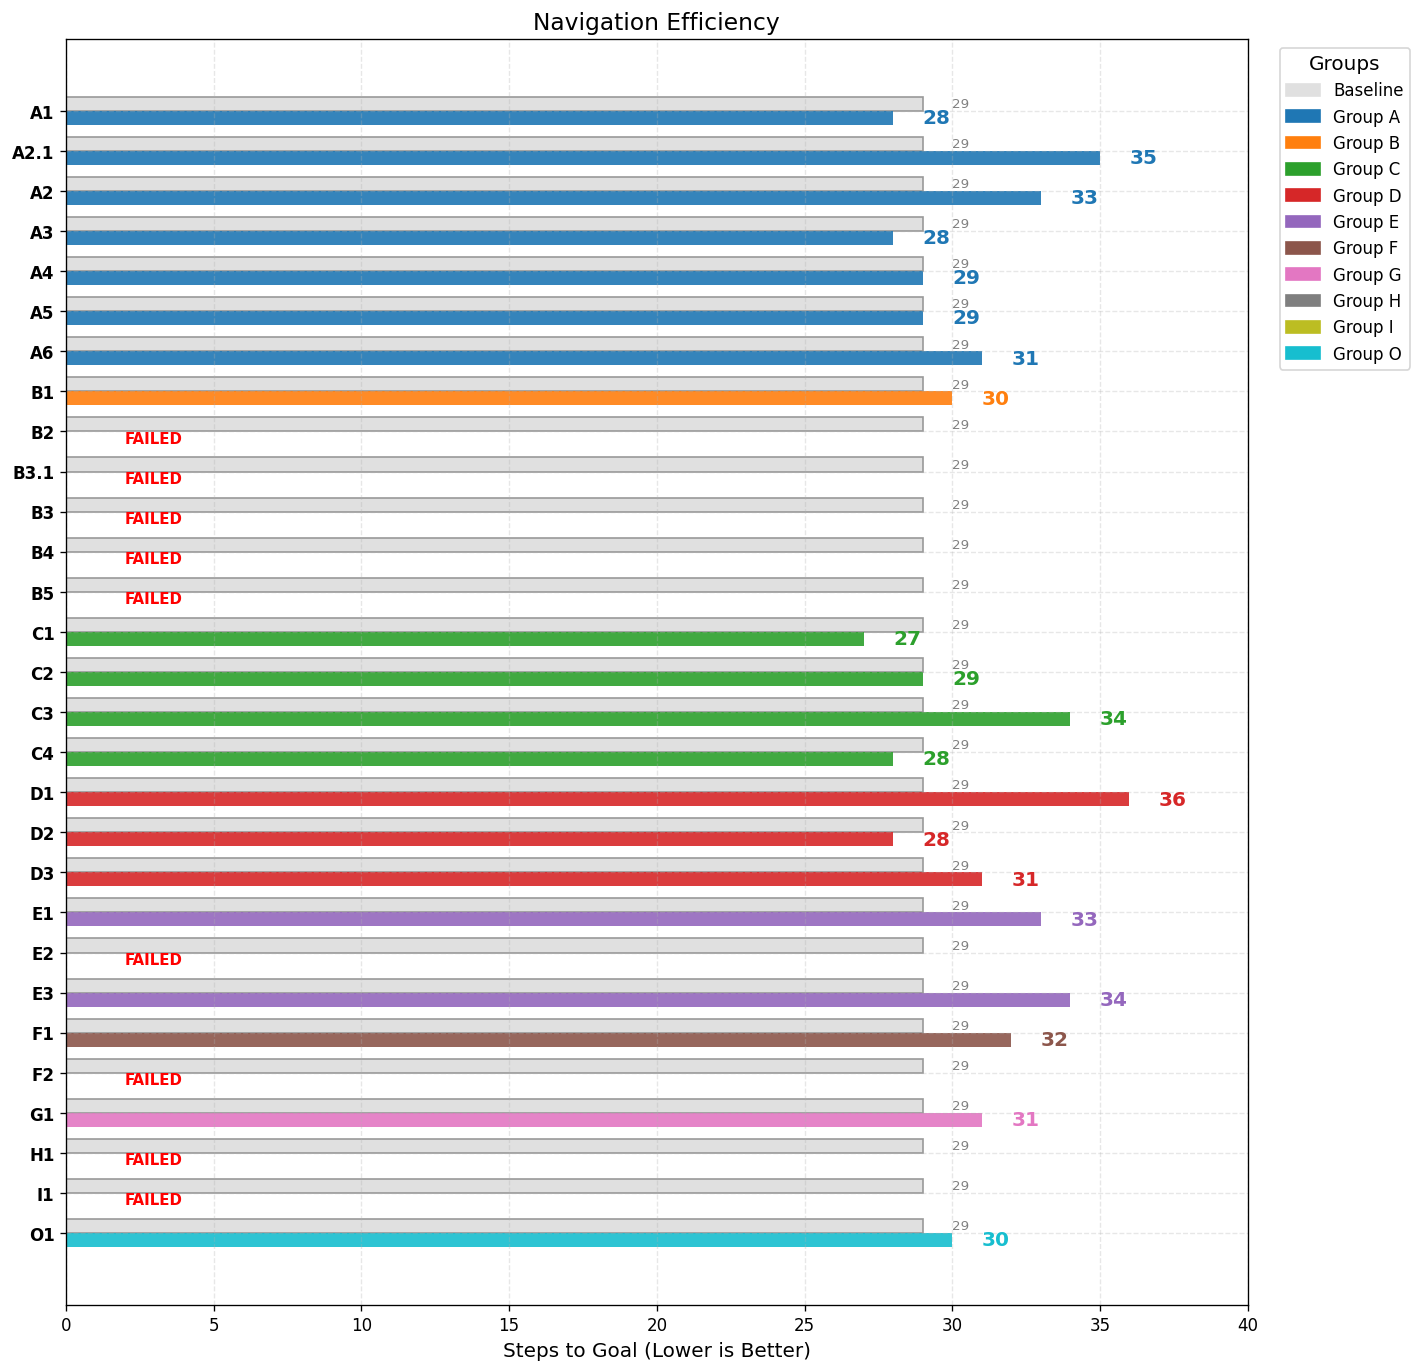

Applicazione offset manuale...


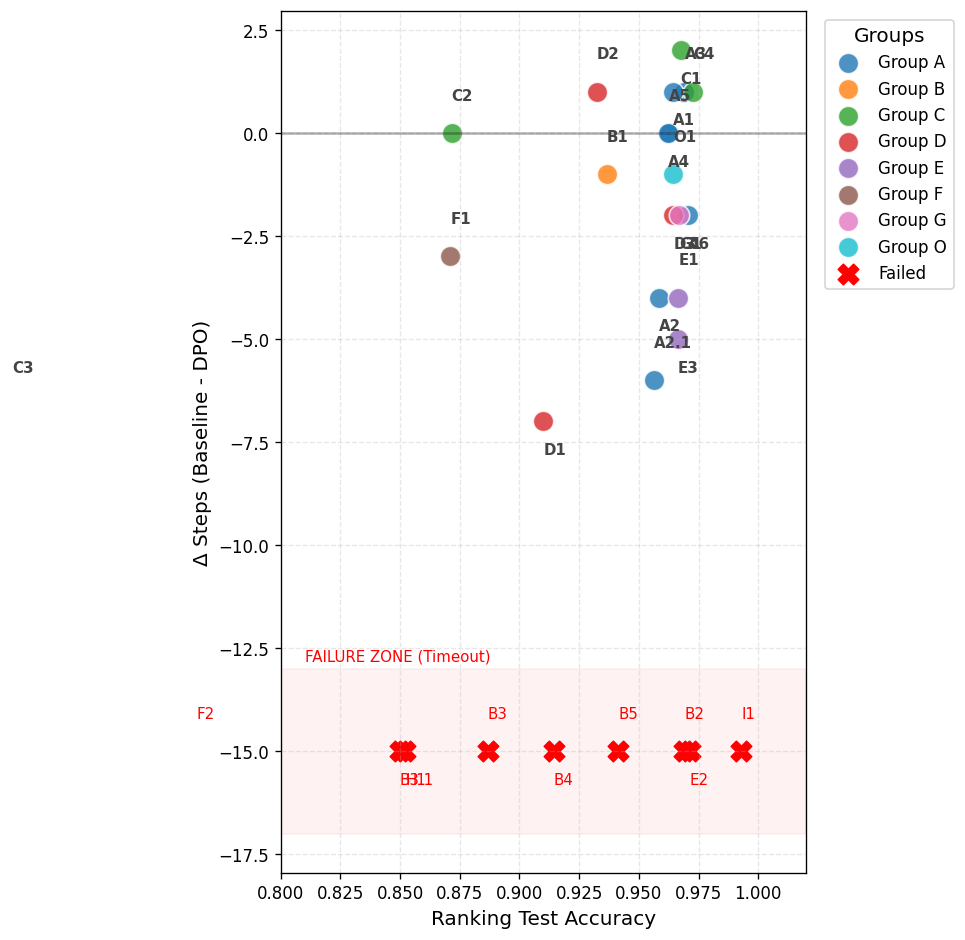

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from pathlib import Path

# --- PROVA A IMPORTARE adjustText (Opzionale ma raccomandato) ---
try:
    from adjustText import adjust_text
    ADJUST_TEXT_OK = True
except ImportError:
    ADJUST_TEXT_OK = False
    print("Nota: Installa 'adjustText' (pip install adjustText) per un posizionamento etichette perfetto.")

# --- CONFIGURAZIONE STILE ---
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.figsize': (12, 8),
    'figure.dpi': 120, # DPI più basso per visualizzazione notebook veloce
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--'
})

# Colori
GROUP_COLORS = {
    'A': '#1f77b4', 'B': '#ff7f0e', 'C': '#2ca02c', 'D': '#d62728',
    'E': '#9467bd', 'F': '#8c564b', 'G': '#e377c2', 'H': '#7f7f7f',
    'I': '#bcbd22', 'O': '#17becf'
}

def get_group(test_id):
    return test_id.split('_')[0][0] if isinstance(test_id, str) else '?'

def load_data(csv_path):
    df = pd.read_csv(csv_path)
    df['Group'] = df['test_id'].apply(get_group)
    df = df.sort_values('test_id', ascending=False).reset_index(drop=True)
    return df

# --- 1. COMPARAZIONE PASSI (BAR CHART) ---
def plot_steps_comparison(df):
    fig, ax = plt.subplots(figsize=(12, max(6, len(df)*0.4)))
    
    y = np.arange(len(df))
    height = 0.35
    
    dpo_vals = df['dpo_steps'].fillna(0)
    is_nan = df['dpo_steps'].isna()
    
    # Baseline
    ax.barh(y + height/2, df['baseline_steps'], height, label='Baseline (A*)', color='#e0e0e0', edgecolor='#999999')
    
    # DPO
    colors = [GROUP_COLORS.get(g, '#333') for g in df['Group']]
    ax.barh(y - height/2, dpo_vals, height, label='DPO Policy', color=colors, alpha=0.9)
    
    # Etichette Y
    clean_labels = [t.split('_')[0] for t in df['test_id']]
    ax.set_yticks(y)
    ax.set_yticklabels(clean_labels, fontweight='bold')
    ax.set_xlabel("Steps to Goal (Lower is Better)")
    ax.set_title("Navigation Efficiency")
    
    # Scala asse X (taglio outlier)
    ax.set_xlim(0, 40) 

    # Annotazioni
    for i, (val, nan, base) in enumerate(zip(dpo_vals, is_nan, df['baseline_steps'])):
        # Scrivi baseline
        ax.text(base + 1, i + height/2, f"{int(base)}", va='center', color='gray', fontsize=8)
        
        if nan:
            ax.text(2, i - height/2, "FAILED", color='red', va='center', fontweight='bold', fontsize=9)
        elif val > 100:
            ax.text(95, i - height/2, f"{int(val)} >", color='white', va='center', fontweight='bold')
        else:
            txt_col = 'black' if colors[i] == '#F0E442' else colors[i] # Contrasto per il giallo
            ax.text(val + 1, i - height/2, f"{int(val)}", va='center', fontweight='bold', color=txt_col)

    # LEGENDA ESTERNA
    handles = [mpatches.Patch(color='#e0e0e0', label='Baseline')]
    for g in sorted(df['Group'].unique()):
        handles.append(mpatches.Patch(color=GROUP_COLORS.get(g, '#333'), label=f'Group {g}'))
        
    ax.legend(handles=handles, bbox_to_anchor=(1.02, 1), loc='upper left', title="Groups")
    
    plt.tight_layout()
    plt.show() # MOSTRA NEL NOTEBOOK

# --- 2. ACCURACY vs DELTA (SCATTER PLOT) ---
def plot_accuracy_vs_delta(df):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    success = df.dropna(subset=['delta_steps'])
    failed = df[df['delta_steps'].isna()]
    
    # Calcolo posizione "Failure Zone" (sotto il minimo)
    min_delta = success['delta_steps'].min()
    failure_y = min_delta - 8 
    
    # Sfondo Failure Zone
    ax.axhspan(failure_y - 2, failure_y + 2, color='red', alpha=0.05)
    ax.text(0.81, failure_y + 2.2, "FAILURE ZONE (Timeout)", color='red', fontsize=9)

    # Plot Successi
    for g in sorted(success['Group'].unique()):
        subset = success[success['Group'] == g]
        ax.scatter(subset['test_accuracy'], subset['delta_steps'], 
                   color=GROUP_COLORS[g], s=150, alpha=0.8, 
                   edgecolors='white', linewidth=1, label=f"Group {g}")

    # Plot Fallimenti (Pallino Rosso)
    if not failed.empty:
        ax.scatter(failed['test_accuracy'], [failure_y]*len(failed),
                   color='red', marker='X', s=150, label='Failed')

    ax.axhline(0, color='black', linestyle='-', alpha=0.3)
    
    # Etichette (Labels)
    texts = []
    
    # Etichette Successi
    for i, row in success.iterrows():
        label = row['test_id'].split('_')[0]
        t = ax.text(row['test_accuracy'], row['delta_steps'], label, fontsize=9, fontweight='bold', color='#444')
        texts.append(t)
    
    # Etichette Fallimenti
    for i, row in failed.iterrows():
        label = row['test_id'].split('_')[0]
        t = ax.text(row['test_accuracy'], failure_y, label, fontsize=9, color='red')
        texts.append(t)

    # DISTANZIAMENTO ETICHETTE
    if ADJUST_TEXT_OK:
        # Metodo automatico (migliore)
        adjust_text(texts, ax=ax, expand_points=(1.5, 1.5), arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
    else:
        # Metodo manuale (alternanza su/giù per evitare sovrapposizioni base)
        print("Applicazione offset manuale...")
        for i, t in enumerate(texts):
            pos = t.get_position()
            offset = 0.8 if i % 2 == 0 else -0.8 # Alterna sopra/sotto
            t.set_position((pos[0], pos[1] + offset))

    ax.set_xlabel("Ranking Test Accuracy")
    ax.set_ylabel("Δ Steps (Baseline - DPO)")
    ax.set_xlim(0.80, 1.02)
    
    # Legenda Esterna
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="Groups")
    
    plt.tight_layout()
    plt.show() # MOSTRA NEL NOTEBOOK

# --- MAIN ---
try:
    # Cerca il CSV nella directory corrente o sottocartelle
    csv_path = list(Path(".").rglob("_metrics_summary.csv"))[0]
    df = load_data(csv_path)
    
    print(f"Dati caricati: {len(df)} esperimenti.")
    plot_steps_comparison(df)
    plot_accuracy_vs_delta(df)

except IndexError:
    print("Errore: _metrics_summary.csv non trovato.")
except Exception as e:
    print(f"Errore: {e}")

Nota: Installa 'adjustText' (pip install adjustText) per un posizionamento etichette perfetto.
Dati caricati: 29 esperimenti.

--- 1. FULL RANGE VIEW (Include F2 e C3) ---


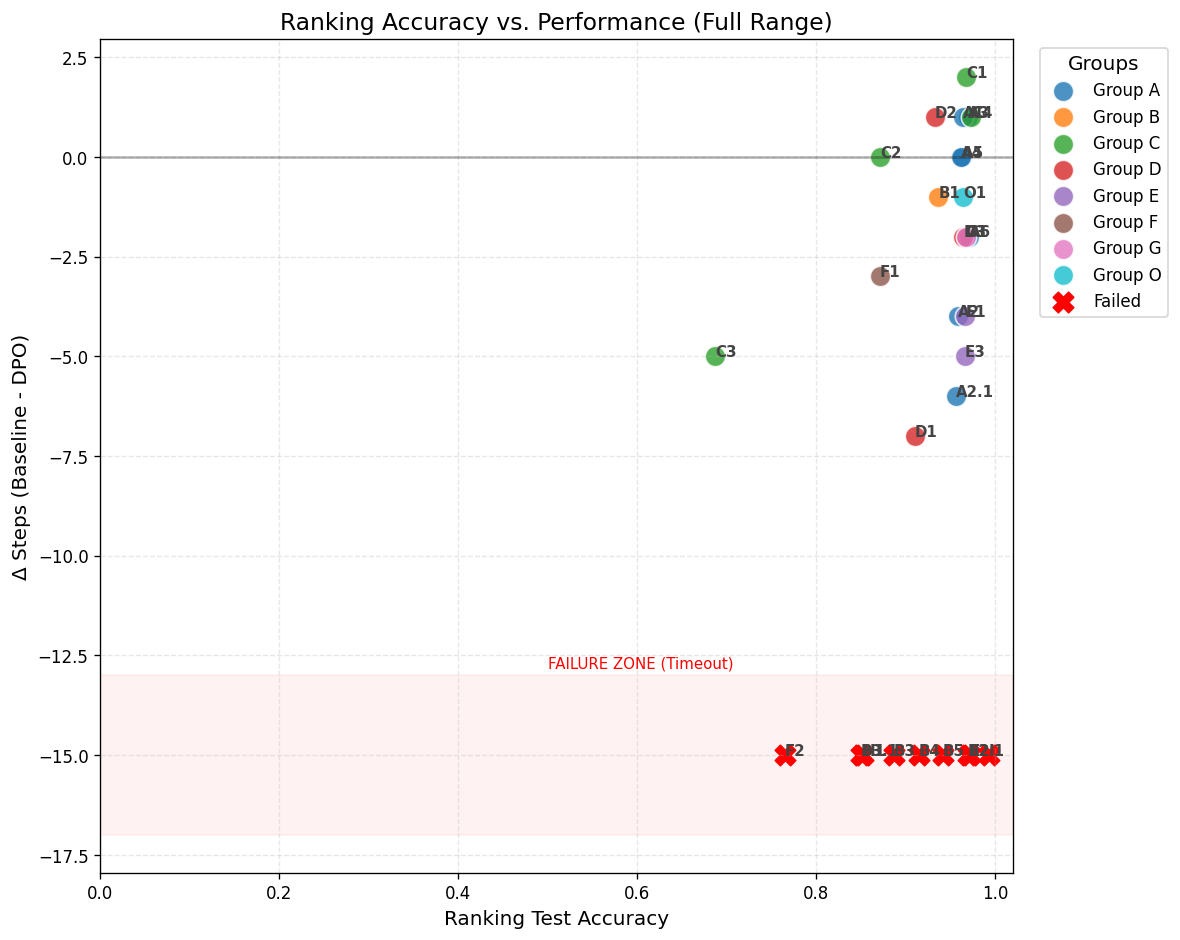


--- 2. ZOOMED VIEW (Focus sui migliori) ---


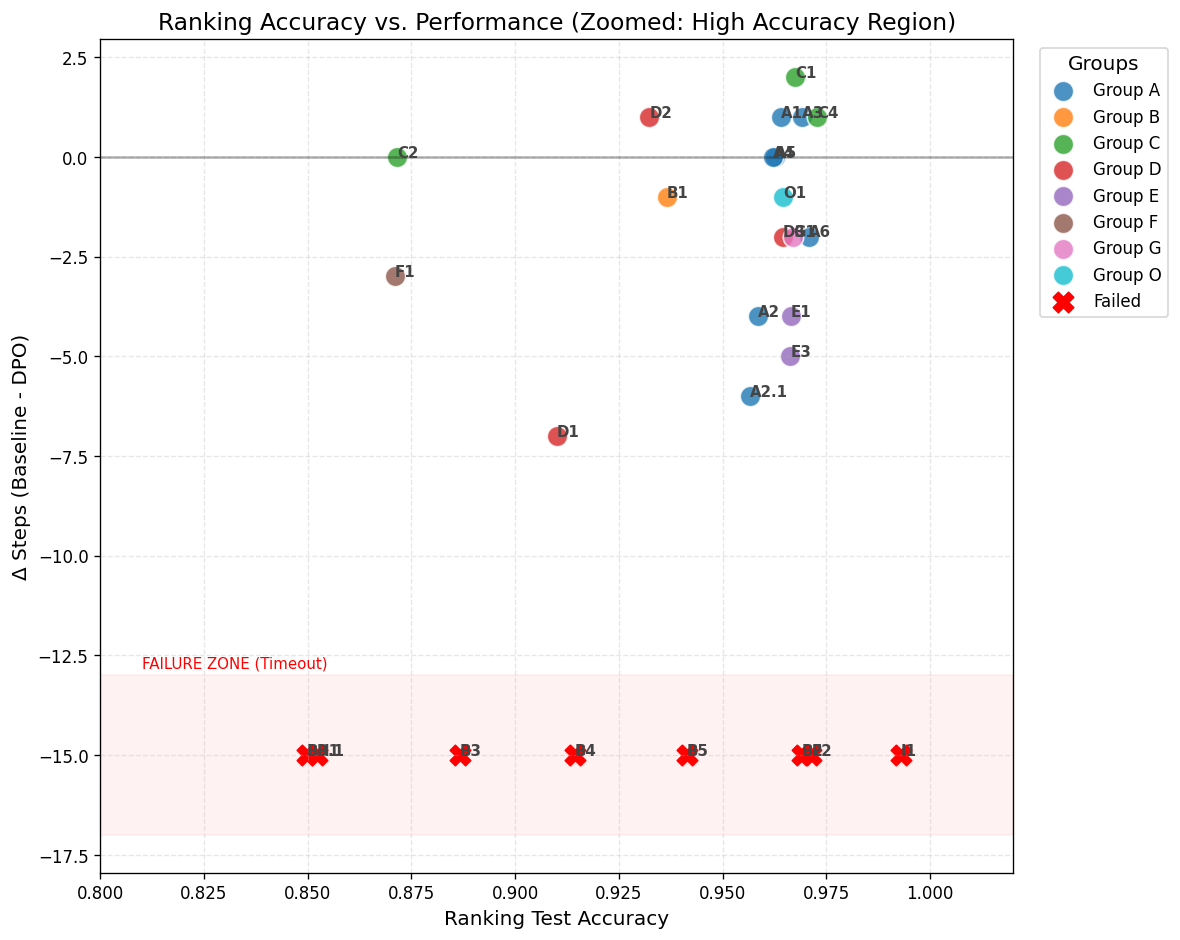

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from pathlib import Path

# --- PROVA A IMPORTARE adjustText ---
try:
    from adjustText import adjust_text
    ADJUST_TEXT_OK = True
except ImportError:
    ADJUST_TEXT_OK = False
    print("Nota: Installa 'adjustText' (pip install adjustText) per un posizionamento etichette perfetto.")

# --- CONFIGURAZIONE STILE ---
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.figsize': (12, 8),
    'figure.dpi': 120,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--'
})

# Colori
GROUP_COLORS = {
    'A': '#1f77b4', 'B': '#ff7f0e', 'C': '#2ca02c', 'D': '#d62728',
    'E': '#9467bd', 'F': '#8c564b', 'G': '#e377c2', 'H': '#7f7f7f',
    'I': '#bcbd22', 'O': '#17becf'
}

def get_group(test_id):
    return test_id.split('_')[0][0] if isinstance(test_id, str) else '?'

def load_data(csv_path):
    df = pd.read_csv(csv_path)
    df['Group'] = df['test_id'].apply(get_group)
    df = df.sort_values('test_id', ascending=False).reset_index(drop=True)
    return df

# --- 2. ACCURACY vs DELTA (SCATTER PLOT - DUAL VIEW) ---
def plot_accuracy_vs_delta(df, zoom=True):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    success = df.dropna(subset=['delta_steps'])
    failed = df[df['delta_steps'].isna()]
    
    # Calcolo posizione "Failure Zone"
    min_delta = success['delta_steps'].min()
    failure_y = min_delta - 8 
    
    # Sfondo Failure Zone
    ax.axhspan(failure_y - 2, failure_y + 2, color='red', alpha=0.05)
    ax.text(0.5 if not zoom else 0.81, failure_y + 2.2, "FAILURE ZONE (Timeout)", color='red', fontsize=9)

    # Plot Successi
    for g in sorted(success['Group'].unique()):
        subset = success[success['Group'] == g]
        ax.scatter(subset['test_accuracy'], subset['delta_steps'], 
                   color=GROUP_COLORS[g], s=150, alpha=0.8, 
                   edgecolors='white', linewidth=1, label=f"Group {g}")

    # Plot Fallimenti
    if not failed.empty:
        ax.scatter(failed['test_accuracy'], [failure_y]*len(failed),
                   color='red', marker='X', s=150, label='Failed')

    ax.axhline(0, color='black', linestyle='-', alpha=0.3)
    
    # Etichette
    texts = []
    all_points = pd.concat([success, failed])
    
    for i, row in all_points.iterrows():
        label = row['test_id'].split('_')[0]
        y_pos = row['delta_steps'] if pd.notna(row['delta_steps']) else failure_y
        
        # Filtra etichette fuori dallo zoom per pulizia
        if zoom and row['test_accuracy'] < 0.80:
            continue
            
        t = ax.text(row['test_accuracy'], y_pos, label, fontsize=9, fontweight='bold', color='#444')
        texts.append(t)

    # DISTANZIAMENTO ETICHETTE
    if ADJUST_TEXT_OK:
        adjust_text(texts, ax=ax, expand_points=(1.5, 1.5), arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    ax.set_xlabel("Ranking Test Accuracy")
    ax.set_ylabel("Δ Steps (Baseline - DPO)")
    
    if zoom:
        ax.set_title("Ranking Accuracy vs. Performance (Zoomed: High Accuracy Region)")
        ax.set_xlim(0.80, 1.02) # Taglia fuori C3 e F2 se sono bassi
    else:
        ax.set_title("Ranking Accuracy vs. Performance (Full Range)")
        ax.set_xlim(0.0, 1.02) # Mostra tutto
    
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="Groups")
    
    plt.tight_layout()
    plt.show()

# --- MAIN ---
try:
    csv_path = list(Path(".").rglob("_metrics_summary.csv"))[0]
    df = load_data(csv_path)
    
    print(f"Dati caricati: {len(df)} esperimenti.")
    
    print("\n--- 1. FULL RANGE VIEW (Include F2 e C3) ---")
    plot_accuracy_vs_delta(df, zoom=False)
    
    print("\n--- 2. ZOOMED VIEW (Focus sui migliori) ---")
    plot_accuracy_vs_delta(df, zoom=True)

except IndexError:
    print("Errore: _metrics_summary.csv non trovato.")
except Exception as e:
    print(f"Errore: {e}")